In [43]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

In [44]:
data = pd.read_csv('C:/Users/SIMPLON/Desktop/FAKE_NEWS/text.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

In [45]:
df=data.copy()
#df.head()
y=df.is_fake
X=df.text

In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(X)

max_length = 700
vocab_size = 6000

sequences = tokenizer.texts_to_sequences(X)


padded= pad_sequences(sequences, padding = 'post', maxlen=max_length)


X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2,random_state= 2022,stratify=y)

print(X_train.shape)
print(y_train.shape)

(35917, 700)
(35917,)


In [47]:
def get_simple_LSTM_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = get_simple_LSTM_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 700, 10)           60000     
                                                                 
 dropout_3 (Dropout)         (None, 700, 10)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                6464      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

# Model1

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])

In [7]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                                  verbose=1, mode="min", restore_best_weights=True)
]

In [8]:

history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

print(history.history.keys())

Epoch 1/20
1123/1123 [==============================] - 859s 761ms/step - loss: 0.5268 - precision: 0.6788 - accuracy: 0.0000e+00 - val_loss: 0.4378 - val_precision: 0.7379 - val_accuracy: 0.0000e+00
Epoch 2/20
1123/1123 [==============================] - 799s 712ms/step - loss: 0.3921 - precision: 0.7875 - accuracy: 0.0000e+00 - val_loss: 0.2114 - val_precision: 0.9716 - val_accuracy: 0.0000e+00
Epoch 3/20
1123/1123 [==============================] - 812s 723ms/step - loss: 0.4994 - precision: 0.6617 - accuracy: 0.0000e+00 - val_loss: 0.2133 - val_precision: 0.9821 - val_accuracy: 0.0000e+00
Epoch 4/20
1123/1123 [==============================] - 751s 669ms/step - loss: 0.2747 - precision: 0.8968 - accuracy: 0.0000e+00 - val_loss: 0.6286 - val_precision: 0.5604 - val_accuracy: 0.0000e+00
Epoch 5/20
1123/1123 [==============================] - 837s 746ms/step - loss: 0.3385 - precision: 0.7988 - accuracy: 0.0000e+00 - val_loss: 0.1806 - val_precision: 0.9561 - val_accuracy: 0.0000e+00


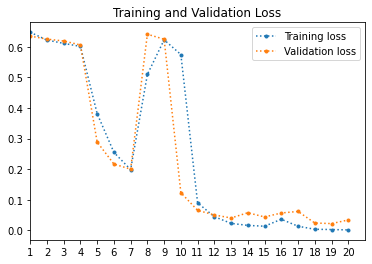

KeyError: 'precision'

In [41]:
# plot training and validation loss

metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

# plot training and validation precision

metric_to_plot = 'precision'
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Precision')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

# plot training and validation recall

metric_to_plot = "accuracy"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Recall')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [19]:
predict_x=model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)

In [21]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print(classification_report(y_test,y_pred ))
print(confusion_matrix(y_test, y_pred))

rfc2_f1 = round(f1_score(y_test,y_pred , average='weighted'), 3)
rfc2_accuracy = round((accuracy_score(y_test, y_pred )*100),2)

print("Accuracy : " , rfc2_accuracy , " %")
print("f1_score : " , rfc2_f1)

              precision    recall  f1-score   support

           0       0.48      1.00      0.65      4283
           1       0.00      0.00      0.00      4697

    accuracy                           0.48      8980
   macro avg       0.24      0.50      0.32      8980
weighted avg       0.23      0.48      0.31      8980

[[4283    0]
 [4697    0]]
Accuracy :  47.69  %
f1_score :  0.308


# Model2

In [53]:

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, 10, input_length=max_length))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])

In [54]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(X_test, y_test), 
                    )

Epoch 1/20
1123/1123 [==============================] - 886s 786ms/step - loss: 0.5806 - precision_1: 0.6382 - accuracy: 0.0000e+00 - val_loss: 0.6472 - val_precision_1: 0.9010 - val_accuracy: 0.0000e+00
Epoch 2/20
1123/1123 [==============================] - 827s 737ms/step - loss: 0.5134 - precision_1: 0.6726 - accuracy: 0.0000e+00 - val_loss: 0.6274 - val_precision_1: 0.5569 - val_accuracy: 0.0000e+00
Epoch 3/20
1123/1123 [==============================] - 833s 742ms/step - loss: 0.4690 - precision_1: 0.6853 - accuracy: 0.0000e+00 - val_loss: 0.2001 - val_precision_1: 0.9629 - val_accuracy: 0.0000e+00
Epoch 4/20
1123/1123 [==============================] - 854s 761ms/step - loss: 0.3174 - precision_1: 0.8303 - accuracy: 0.0000e+00 - val_loss: 0.2781 - val_precision_1: 0.9461 - val_accuracy: 0.0000e+00
Epoch 5/20
1123/1123 [==============================] - 793s 706ms/step - loss: 0.5666 - precision_1: 0.6180 - accuracy: 0.0000e+00 - val_loss: 0.4512 - val_precision_1: 0.8523 - val_a

In [36]:
predict_x=model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)

In [56]:
model.evaluate(X_train,y_train)

1123/1123 [==============================] - 272s 242ms/step - loss: 0.0061 - precision_1: 0.9986 - accuracy: 0.0000e+00


[0.006062592379748821, 0.9986156821250916, 0.0]

In [55]:
model.evaluate(X_test,y_test)

281/281 [==============================] - 68s 240ms/step - loss: 0.0288 - precision_1: 0.9903 - accuracy: 0.0000e+00


[0.028808820992708206, 0.9902521967887878, 0.0]

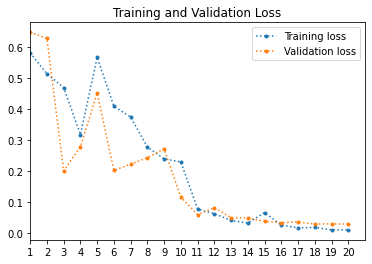

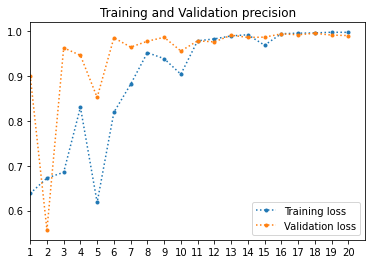

In [60]:
# plot training and validation loss

metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()




# plot training and validation precision

metric_to_plot = "precision_1"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation precision')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()